# INFO4604 Project: Vehicle detection

Xinyi Lu

Cynthia Lim

In [1]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [2]:
!pip install keras

In [3]:
!pip install tensorflow

In [1]:
import os
import cv2 # pip install opencv-python
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images
import numpy as np 
from glob import glob
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
from sklearn.svm import SVC
import tensorflow as tf
%matplotlib inline
import warnings
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

**Tensor Flow**

**1. Import the data**

In [2]:
vehicle_dir = 'data/vehicles/'
non_vehicle_dir = 'data/non-vehicles/'

In [3]:
vehicle_names = os.listdir(vehicle_dir)
non_vehicle_names = os.listdir(non_vehicle_dir)

**2. Explore the data**

In [4]:
print("No of vehicle images:", len(vehicle_names))
print("No of non-vehicle images:", len(non_vehicle_names))

No of vehicle images: 8792
No of non-vehicle images: 8968


**3. Prepare the Data**

In [5]:
# here we create and attach labels to our data
cat = {
    'non-vehicles': 0,
    'vehicles': 1
}

# get all the paths for vehicles and non-vehicles
def get_paths(folder):
    
    path = []
    labels = []
    for dirname, _, filenames in os.walk(folder):
        dir_class = dirname.split('/')[1] # either vehicles or non-vehicles
        for filename in filenames:
            path.append(os.path.join(dirname, filename))
            labels.append(cat[dir_class])
    
    return pd.DataFrame({'path': path, 'class': labels})

In [6]:
vehicles_df = get_paths(vehicle_dir)
vehicles_df.head()

,path,class
0,data/vehicles/1.png,1
1,data/vehicles/10.png,1
2,data/vehicles/1000.png,1
3,data/vehicles/1001.png,1
4,data/vehicles/1002.png,1


In [7]:
non_vehicles_df = get_paths(non_vehicle_dir)
non_vehicles_df.head()

,path,class
0,data/non-vehicles/extra1.png,0
1,data/non-vehicles/extra10.png,0
2,data/non-vehicles/extra100.png,0
3,data/non-vehicles/extra1000.png,0
4,data/non-vehicles/extra1001.png,0


In [8]:
df = pd.concat([vehicles_df, non_vehicles_df])
df.shape

(17760, 2)

In [9]:
df.head()

,path,class
0,data/vehicles/1.png,1
1,data/vehicles/10.png,1
2,data/vehicles/1000.png,1
3,data/vehicles/1001.png,1
4,data/vehicles/1002.png,1


In [10]:
# shuffle dataset using sample
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.head()

,path,class
0,data/vehicles/3519.png,1
1,data/non-vehicles/image604.png,0
2,data/vehicles/5546.png,1
3,data/non-vehicles/image525.png,0
4,data/vehicles/far (574).png,1


In [11]:
# we sampled the first 200 rows to start out
sample_df = df.iloc[:, :] # if you want to sample just the first 200 rows do -> sample_df = df.iloc[:200, :]
sample_df

,path,class
0,data/vehicles/3519.png,1
1,data/non-vehicles/image604.png,0
2,data/vehicles/5546.png,1
3,data/non-vehicles/image525.png,0
4,data/vehicles/far (574).png,1
...,...,...
17755,data/non-vehicles/extra334.png,0
17756,data/non-vehicles/image575.png,0
17757,data/vehicles/5675.png,1
17758,data/non-vehicles/extra4531.png,0


In [12]:
sample_df['class'].value_counts() 

0    8968
1    8792
Name: class, dtype: int64

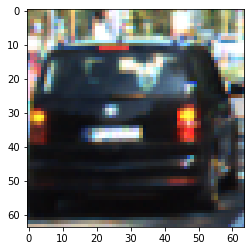

In [13]:
# read in an image
im = mpimg.imread(sample_df['path'][0])
plt.imshow(im)

In [14]:
def load_images(paths, img_size):
    images = []
    
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, img_size) #resize the images
        img = np.array(img)
        
        images.append(img)
    
    images = np.array(images)
    images = images.astype(np.int64)
    
    return images

In [15]:
images = load_images(sample_df['path'], (64, 64))
print(images.shape)

(17760, 64, 64, 3)


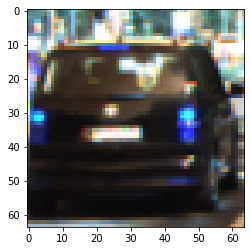

In [16]:
plt.imshow(images[0])

In [17]:
x = images
y = sample_df["class"]

#train test split - 75% train, 25% test

x_training, x_test = x[:13320,:], x[13320:,:]
y_training, y_test = y[:13320], y[13320:]

In [18]:
x_training.shape

(13320, 64, 64, 3)

In [19]:
x_test.shape

(4440, 64, 64, 3)

In [20]:
y_training.shape

(13320,)

In [21]:
y_test.shape

(4440,)

In [22]:
# increases accuracy (even when not using loss function) 
tf.cast(x_training, tf.int64)
tf.cast(y_training, tf.int64)

<tf.Tensor: shape=(13320,), dtype=int64, numpy=array([1, 0, 1, ..., 0, 1, 1], dtype=int64)>

**4. Build the Model**

In [23]:
# TensorFlow and tf.keras from Professor Shah's readImages-instructor.ipynb
vehicle_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2), 
    tf.keras.layers.Dense(2, activation = 'softmax')
])

**5. Train the Model & 6. Evaluate the Model**

In [24]:
vehicle_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
vehicle_model.fit(x_training, y_training, epochs=50)

Epoch 1/50
417/417 [==============================] - 10s 19ms/step - loss: 23.0579 - accuracy: 0.7945
Epoch 2/50
417/417 [==============================] - 6s 15ms/step - loss: 4.6502 - accuracy: 0.8421
Epoch 3/50
417/417 [==============================] - 6s 14ms/step - loss: 2.3446 - accuracy: 0.8715
Epoch 4/50
417/417 [==============================] - 5s 13ms/step - loss: 1.7177 - accuracy: 0.8660
Epoch 5/50
417/417 [==============================] - 5s 12ms/step - loss: 0.8486 - accuracy: 0.8929
Epoch 6/50
417/417 [==============================] - 5s 11ms/step - loss: 0.5691 - accuracy: 0.9036
Epoch 7/50
417/417 [==============================] - 4s 11ms/step - loss: 0.3214 - accuracy: 0.9187
Epoch 8/50
417/417 [==============================] - 5s 11ms/step - loss: 0.1825 - accuracy: 0.9399
Epoch 9/50
417/417 [==============================] - 5s 11ms/step - loss: 0.1533 - accuracy: 0.9418
Epoch 10/50
417/417 [==============================] - 5s 11ms/step - loss: 0.1438 - accu

**7. Make Predictions**

In [26]:
print("Tf/keras Accuracy Score: " + str(vehicle_model.evaluate(x_test, y_test, batch_size=5)[1]))

888/888 [==============================] - 2s 2ms/step - loss: 0.1833 - accuracy: 0.9367
Tf/keras Accuracy Score: 0.9367117285728455


## SVM

**1. Import the data (done above)**

**2. Explore the data (done above)**

**3. Prepare the data**

In [27]:
#SVM takes 2D input to train
X_train = np.array(x_training).reshape(len(x_training), -1)
X_train.shape

(13320, 12288)

In [28]:
y_training.shape

(13320,)

In [29]:
X_test = np.array(x_test).reshape(len(x_test), -1)
X_test.shape

(4440, 12288)

**4. Build the model, 5. Train the model & 7. Make the predictions**

In [30]:
# SVM model
svc = SVC(probability=True)
svc.fit(X_train, y_training)
y_pred2 = svc.predict(X_test)

**6. Evaluate the Model**

In [31]:
print("SVM Accuracy Score: " + str(accuracy_score(y_test, y_pred2)))

SVM Accuracy Score: 0.977027027027027


### Results comparison

Typically, the SVM model performs results in a lower prediction accuracy than the tf/keras model. However, in our project, the SVM model has a higher test accuracy than the tf/keras model. 

We chose the SVM model as our discretionary model because it is fast to train and does not require large number of observations. 
Additionally we chose the TF/Keras model for its ease in working with large scale data. 